Подключаем необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Объявляем функции

In [2]:
#Вычисляет среднюю абсолютную процентную ошибку
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Вычисляет медианную абсолютную процентную ошибку
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

#Печатает рассчитанные значения коэффициента детерминации, средней и медианной абсолютных ошибок
def print_metrics(prediction, val_y):
    val_mae = mean_absolute_error(val_y, prediction)
    median_AE = median_absolute_error(val_y, prediction)
    r2 = r2_score(val_y, prediction)

    print('')
    print('R\u00b2: {:.2}'.format(r2))
    print('')
    print('Средняя абсолютная ошибка: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Медианная абсолютная ошибка: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))

Загружаем датасет и делаем первичную обработку

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.fillna(0)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,5613,145,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
1,7968,143,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2,7842,143,1.0,40.409907,0.000000,1.0,10,22.0,1977,0.007122,B,B,1,264,0,0.0,0,1,B,168106.007630
3,1797,7,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,0.0,0,6,B,343995.102962
4,8933,171,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,8203,63,1.0,43.303458,21.519087,8.0,12,14.0,1992,0.161532,B,B,25,5648,1,30.0,2,4,B,136744.340827
7996,5013,58,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,0.0,1,9,B,119367.455796
7997,7685,207,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,0.0,0,0,A,199715.148807
7998,6783,44,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,0.0,1,5,B,165953.912580


In [4]:
test_df.fillna(0)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,1109,207,3.0,115.027311,0.000000,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,0.0,0,0,B
1,5304,143,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,0.0,0,1,B
2,7077,26,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,0.0,3,9,B
3,2199,178,1.0,36.673407,16.285522,9.0,3,12.0,2003,0.041116,B,B,53,14892,4,0.0,1,4,B
4,5205,174,2.0,46.760177,29.829147,6.0,4,9.0,1974,0.089040,B,B,33,7976,5,0.0,0,11,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7153,21,2.0,55.860952,34.465327,8.0,3,7.0,1961,0.049863,B,B,18,3746,9,75.0,3,1,B
1996,7729,101,2.0,38.676356,22.427115,6.0,2,9.0,1967,0.000000,B,B,18,3374,5,620.0,1,2,B
1997,6128,81,1.0,34.723984,19.840550,9.0,6,16.0,1988,0.521867,B,B,25,6149,0,0.0,0,0,B
1998,9764,188,2.0,50.902724,27.159548,6.0,4,9.0,1972,0.127812,B,B,28,7287,5,320.0,1,3,B


In [5]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8000.000000,8000.000000,8000.000000,8000.000000,6296.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,4155.000000,8000.000000,8000.000000,8000.000000
mean,4987.608750,110.822500,1.893750,56.366504,37.348690,6.106375,8.541000,12.598875,4.491401e+03,0.118622,24.661375,5332.776250,7.847125,1143.246209,1.324000,4.194125,214605.477542
std,2882.340831,57.413814,0.825861,20.518022,95.667433,22.521905,5.256118,6.851795,2.241661e+05,0.119217,17.512011,3991.217955,23.224156,1033.605378,1.497933,4.735477,93550.205075
min,0.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,2485.750000,63.000000,1.000000,41.800063,22.765329,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,325.000000,0.000000,1.000000,153994.680334
50%,4987.500000,116.000000,2.000000,52.619610,32.726626,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192034.691671
75%,7470.500000,145.000000,2.000000,66.036608,45.204687,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,5.000000,249970.954618
max,9999.000000,209.000000,10.000000,604.705972,7480.592129,1970.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [6]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,2000.000000,2000.000000,2000.000000,2000.000000,1591.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,1047.000000,2000.000000,2000.000000
mean,5047.065000,109.961000,1.877500,56.112859,36.609834,6.941000,8.469500,12.651500,1985.226000,0.119802,24.789500,5429.682000,8.807500,1141.548233,1.301500,4.380000
std,2905.281024,57.369993,0.892128,23.099741,25.554637,45.276909,5.181746,6.465288,18.455249,0.118281,17.618808,4068.616739,26.113874,972.540534,1.476377,5.078434
min,12.000000,0.000000,0.000000,2.596351,1.104689,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,2559.250000,63.000000,1.000000,41.637552,22.818785,1.000000,4.000000,9.000000,1974.000000,0.020741,6.000000,1741.000000,0.000000,540.000000,0.000000,1.000000
50%,5034.000000,113.000000,2.000000,51.905879,32.894101,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5288.000000,2.000000,990.000000,1.000000,3.000000
75%,7576.500000,143.000000,2.000000,65.087816,44.817314,9.000000,12.000000,17.000000,2002.000000,0.195781,35.000000,7287.000000,4.000000,1450.000000,2.000000,6.000000
max,9998.000000,209.000000,19.000000,641.065193,638.163193,2014.000000,33.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8000 non-null   int64  
 1   DistrictId     8000 non-null   int64  
 2   Rooms          8000 non-null   float64
 3   Square         8000 non-null   float64
 4   LifeSquare     6296 non-null   float64
 5   KitchenSquare  8000 non-null   float64
 6   Floor          8000 non-null   int64  
 7   HouseFloor     8000 non-null   float64
 8   HouseYear      8000 non-null   int64  
 9   Ecology_1      8000 non-null   float64
 10  Ecology_2      8000 non-null   object 
 11  Ecology_3      8000 non-null   object 
 12  Social_1       8000 non-null   int64  
 13  Social_2       8000 non-null   int64  
 14  Social_3       8000 non-null   int64  
 15  Healthcare_1   4155 non-null   float64
 16  Helthcare_2    8000 non-null   int64  
 17  Shops_1        8000 non-null   int64  
 18  Shops_2 

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2000 non-null   int64  
 1   DistrictId     2000 non-null   int64  
 2   Rooms          2000 non-null   float64
 3   Square         2000 non-null   float64
 4   LifeSquare     1591 non-null   float64
 5   KitchenSquare  2000 non-null   float64
 6   Floor          2000 non-null   int64  
 7   HouseFloor     2000 non-null   float64
 8   HouseYear      2000 non-null   int64  
 9   Ecology_1      2000 non-null   float64
 10  Ecology_2      2000 non-null   object 
 11  Ecology_3      2000 non-null   object 
 12  Social_1       2000 non-null   int64  
 13  Social_2       2000 non-null   int64  
 14  Social_3       2000 non-null   int64  
 15  Healthcare_1   1047 non-null   float64
 16  Helthcare_2    2000 non-null   int64  
 17  Shops_1        2000 non-null   int64  
 18  Shops_2 

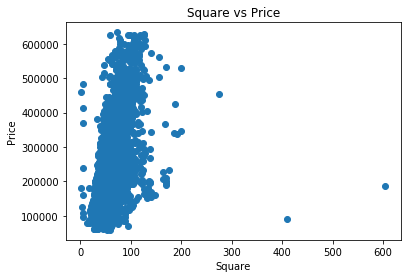

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [9]:
plt.scatter(train_df.Square, train_df.Price)
plt.title('Square vs Price')
plt.xlabel('Square')
plt.ylabel('Price')
plt.show()
sns.despine

In [10]:
num_features = ['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear', 'KitchenSquare', 'Ecology_1', 'Shops_1', 'Helthcare_2']

In [11]:
print(num_features)

['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear', 'KitchenSquare', 'Ecology_1', 'Shops_1', 'Helthcare_2']


In [12]:
X_train = train_df[num_features].values
y_train = train_df['Price'].values
X_test = test_df[num_features].values
test_idxs = test_df['Id'].values

In [13]:
np.nan_to_num(X_train)
print(X_train)

[[1.00000000e+00 3.98325239e+01 7.00000000e+00 ... 1.18537385e-01
  0.00000000e+00 1.00000000e+00]
 [3.00000000e+00 7.83422151e+01 2.00000000e+00 ... 2.56091570e-02
  1.00000000e+00 3.00000000e+00]
 [1.00000000e+00 4.04099069e+01 1.00000000e+01 ... 7.12231700e-03
  1.00000000e+00 0.00000000e+00]
 ...
 [2.00000000e+00 6.43076843e+01 1.30000000e+01 ... 7.21575810e-02
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.96480568e+01 3.00000000e+00 ... 4.60556389e-01
  5.00000000e+00 1.00000000e+00]
 [1.00000000e+00 3.23302924e+01 3.00000000e+00 ... 1.94489265e-01
  5.00000000e+00 3.00000000e+00]]


In [14]:
np.nan_to_num(y_train)
print(y_train)

[177734.55340714 282078.72085004 168106.00763001 ... 199715.14880702
 165953.91258031 171842.41185487]


In [15]:
np.nan_to_num(X_test)
print(X_test)

[[3.00000000e+00 1.15027311e+02 4.00000000e+00 ... 7.54236800e-02
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 4.68878918e+01 1.20000000e+01 ... 7.12231700e-03
  1.00000000e+00 0.00000000e+00]
 [2.00000000e+00 5.39751436e+01 2.00000000e+00 ... 1.27375905e-01
  9.00000000e+00 3.00000000e+00]
 ...
 [1.00000000e+00 3.47239837e+01 6.00000000e+00 ... 5.21867054e-01
  0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 5.09027238e+01 4.00000000e+00 ... 1.27811589e-01
  3.00000000e+00 1.00000000e+00]
 [1.00000000e+00 3.58154765e+01 9.00000000e+00 ... 1.27375905e-01
  9.00000000e+00 3.00000000e+00]]


In [16]:
np.nan_to_num(test_idxs)
print(test_idxs)

[1109 5304 7077 ... 6128 9764 2569]


Модель LinearRegression

In [17]:
model = LinearRegression()

In [18]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
y_pred = model.predict(X_test)

In [20]:
print(y_pred)

[301470.37985318 159390.70104397 232191.2519314  ... 116229.05303853
 195244.53493156 178922.55168498]


In [21]:
submission_df = pd.DataFrame(zip(test_idxs, y_pred), columns = ['Id', 'Price'])
submission_df.to_csv('submission.csv', index=False)

In [22]:
print(submission_df)

        Id          Price
0     1109  301470.379853
1     5304  159390.701044
2     7077  232191.251931
3     2199  141301.411635
4     5205  184900.105779
...    ...            ...
1995  7153  226607.989299
1996  7729  178851.008312
1997  6128  116229.053039
1998  9764  195244.534932
1999  2569  178922.551685

[2000 rows x 2 columns]


In [23]:
df = pd.read_csv('submission.csv')
df.head(15)

,Id,Price
0,1109,301470.379853
1,5304,159390.701044
2,7077,232191.251931
3,2199,141301.411635
4,5205,184900.105779
5,3243,191013.183022
6,9200,220489.463469
7,9729,371221.585996
8,9271,154773.685410
9,1391,158460.084354


Модель Gradient Boosting for regression

In [24]:
from sklearn import ensemble

In [25]:
clf = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')

In [26]:
clf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
t_sc = np.zeros((clf.n_estimators),dtype=np.float64)

In [28]:
print(t_sc)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [29]:
for i,y_pred in enumerate(clf.staged_predict(X_test)):
    t_sc[i]=clf.loss_(test_idxs,y_pred)

In [30]:
testsc = np.arange((clf.n_estimators))+1

In [31]:
print(testsc)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

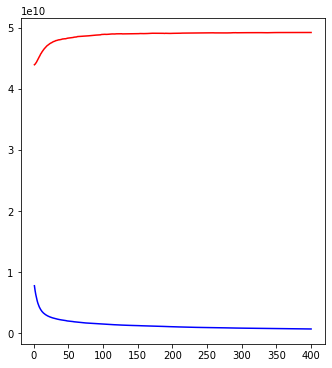

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(testsc,clf.train_score_,'b-',label= 'Set dev train')
plt.plot(testsc,t_sc,'r-',label = 'set dev test')

In [45]:
submission_df1 = pd.DataFrame(zip(test_idxs, y_pred), columns = ['Id', 'Price'])
submission_df1.to_csv('submission1.csv', index=False)

In [46]:
df1 = pd.read_csv('submission1.csv')
df1.head(20)

,Id,Price
0,1109,241008.649992
1,5304,165023.157199
2,7077,254765.905185
3,2199,163212.960658
4,5205,200821.975013
5,3243,298036.366567
6,9200,283137.286718
7,9729,438639.614596
8,9271,192109.212075
9,1391,175224.496734


Удаляем выбросы

In [34]:
#Вычисляем строки со значениями-выбросами 
first_quartile = train_df.quantile(q=0.25)
third_quartile = train_df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = train_df[(train_df > (third_quartile + 1.5 * IQR)) | (train_df < (first_quartile - 1.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)

#Удаляем из датафрейма 400 строк, подходящих под критерии выбросов
outliers = outliers.head(400)
train_df.drop(outliers.index, inplace=True)

In [35]:
print(first_quartile)

Id                 2485.750000
DistrictId           63.000000
Rooms                 1.000000
Square               41.800063
LifeSquare           22.765329
KitchenSquare         1.000000
Floor                 4.000000
HouseFloor            9.000000
HouseYear          1974.000000
Ecology_1             0.017647
Social_1              6.000000
Social_2           1564.000000
Social_3              0.000000
Healthcare_1        325.000000
Helthcare_2           0.000000
Shops_1               1.000000
Price            153994.680334
Name: 0.25, dtype: float64


In [36]:
print(third_quartile)

Id                 7470.500000
DistrictId          145.000000
Rooms                 2.000000
Square               66.036608
LifeSquare           45.204687
KitchenSquare         9.000000
Floor                12.000000
HouseFloor           17.000000
HouseYear          2001.000000
Ecology_1             0.195781
Social_1             36.000000
Social_2           7227.000000
Social_3              5.000000
Healthcare_1       1548.000000
Helthcare_2           2.000000
Shops_1               5.000000
Price            249970.954618
Name: 0.75, dtype: float64


In [37]:
print(IQR)

Id                4984.750000
DistrictId          82.000000
Rooms                1.000000
Square              24.236545
LifeSquare          22.439358
KitchenSquare        8.000000
Floor                8.000000
HouseFloor           8.000000
HouseYear           27.000000
Ecology_1            0.178134
Social_1            30.000000
Social_2          5663.000000
Social_3             5.000000
Healthcare_1      1223.000000
Helthcare_2          2.000000
Shops_1              4.000000
Price            95976.274284
dtype: float64


In [38]:
print(outliers)

1549    7
671     6
1941    6
3581    5
1186    5
       ..
3073    2
3071    2
4078    2
4085    2
4099    2
Length: 400, dtype: int64


Превращаем категорийные признаки в числовые

In [39]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = train_df.columns[train_df.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    train_df[column] = labelencoder.fit_transform(train_df[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
train_df.info()

{0: 'A', 1: 'B'}
{0: 'A', 1: 'B'}
{0: 'A', 1: 'B'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      2000 non-null   int64  
 1   Price   2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [40]:
print(categorical_columns)

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')


Создаем целевую переменную, делим датасет на выборки

In [41]:
#Назначаем целевой переменной цену всей квартиры
y = train_df['Price']

#Создаем список признаков, на основании которых будем строить модели
features = [
            'Rooms', 
            'Square', 
            'Floor', 
            'HouseFloor',
            'HouseYear',
            'KitchenSquare',
            'Ecology_1',
            'Social_1',
            'Social_2',
            'Social_3',
            'Helthcare_2',
            'Shops_1'
           ]

#Создаем датафрейм, состоящий из признаков, выбранных ранее
X = train_df[features]
np.nan_to_num(X)

#Проводим случайное разбиение данных на выборки для обучения (train) и валидации (val), по умолчанию в пропорции 0.75/0.25
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [42]:
print(y)

0       177734.553407
1       282078.720850
2       168106.007630
3       343995.102962
4       161044.944138
            ...      
7995    136744.340827
7996    119367.455796
7997    199715.148807
7998    165953.912580
7999    171842.411855
Name: Price, Length: 7600, dtype: float64


Модель Random forest

In [47]:
#Создаем регрессионную модель случайного леса 
rf_model = RandomForestRegressor(n_estimators=2000, 
                                 n_jobs=-1,  
                                 bootstrap=False,
                                 criterion='mse',
                                 max_features=3,
                                 random_state=1,
                                 max_depth=55,
                                 min_samples_split=5
                                 )

#Проводим подгонку модели на обучающей выборке 
rf_model.fit(train_X, train_y)

#Вычисляем предсказанные значения цен на основе валидационной выборки
rf_prediction = rf_model.predict(val_X).round(0)

#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(rf_prediction, val_y)


R²: 0.69

Средняя абсолютная ошибка: 15.1 %
Медианная абсолютная ошибка: 7.72 %


Модель XGBoost

In [ ]:
#Создаем регрессионную модель XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:gamma', 
                             learning_rate = 0.01,
                             max_depth = 45, 
                             n_estimators = 2000,
                             nthread = -1,
                             eval_metric = 'gamma-nloglik', 
                             )

#Проводим подгонку модели на обучающей выборке 
xgb_model.fit(train_X, train_y)

#Вычисляем предсказанные значения цен на основе валидационной выборки
xgb_prediction = xgb_model.predict(val_X).round(0)

#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(xgb_prediction, val_y)

Усреднение предсказаний моделей

In [ ]:
prediction = rf_prediction * 0.5 + xgb_prediction * 0.5

In [ ]:
print_metrics(prediction, val_y)

Изучаем важность признаков в модели Random forest

Рейтинг важности признаков:
1. Square (0.294883)
2. Rooms (0.148057)
3. Social_1 (0.089824)
4. Social_2 (0.089762)
5. Social_3 (0.076719)
6. KitchenSquare (0.057378)
7. HouseYear (0.053876)
8. Ecology_1 (0.048762)
9. HouseFloor (0.039993)
10. Floor (0.037303)
11. Shops_1 (0.034926)
12. Helthcare_2 (0.028519)


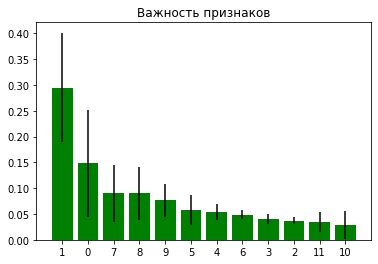

In [48]:
#Рассчитываем важность признаков в модели Random forest
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Печатаем рейтинг признаков
print("Рейтинг важности признаков:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

#Строим столбчатую диаграмму важности признаков
plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Оцениваем квартиру

In [52]:
flat = pd.DataFrame({
                     'Rooms':[2], 
                     'Square':[65],
                     'Floor':[3],
                     'HouseFloor':[5],
                     'HouseYear':[1972],
                     'KitchenSquare':[7],
                    'Ecology_1':[0.1],
                    'Social_1':[20],
                    'Social_2':[500],
                    'Social_3':[8],
                    'Helthcare_2':[1],
                    'Shops_1':[3]
                     })

#Вычисляем предсказанное значение стоимости по модели
rf_prediction_flat = rf_model.predict(flat).round(0)
xgb_prediction_flat = xgb_model.predict(flat).round(0)

#Усредняем полученные значения и умножаем на общую площадь квартиры
price = (rf_prediction_flat * 0.5 + xgb_prediction_flat * 0.5)*flat['Square'][0]

#Печатаем предсказанное значение цены квартиры
print(f'Предсказанная моделью цена квартиры: {int(price[0].round(-3))} рублей')

Предсказанная моделью цена квартиры: 8934000 рублей
